# Predicting Strokes

How well can we predict if a patient will have stroke?  I will use various methods to model the data and compare them to each other.  


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('dark')

import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization



## Data
To test each model, I chose a fairly simple dataset that was obtained on Kaggle.  The data includes basic information about the patient, such as gender and age.  It also includes health info such as bmi, average glucose level, whether or not the patient has hypertension and or heart disease, and smoking history.  The dataset also had the work type and residence type, for information on stress or environmental factors.

In [2]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke.drop(['id'], axis= 1, inplace= True)
stroke.ever_married = stroke.ever_married.map({'Yes': 1, 'No': 0})
stroke.head()


gender   age  hypertension  heart_disease  ever_married      work_type  \
0    Male  67.0             0              1             1        Private   
1  Female  61.0             0              0             1  Self-employed   
2    Male  80.0             0              1             1        Private   
3  Female  49.0             0              0             1        Private   
4  Female  79.0             1              0             1  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

In [3]:
stroke.describe()

age  hypertension  heart_disease  ever_married  \
count  5110.000000   5110.000000    5110.000000   5110.000000   
mean     43.226614      0.097456       0.054012      0.656164   
std      22.612647      0.296607       0.226063      0.475034   
min       0.080000      0.000000       0.000000      0.000000   
25%      25.000000      0.000000       0.000000      0.000000   
50%      45.000000      0.000000       0.000000      1.000000   
75%      61.000000      0.000000       0.000000      1.000000   
max      82.000000      1.000000       1.000000      1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

In [4]:
stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
stroke.dropna(inplace= True)

dummies = ['gender', 'smoking_status', 'work_type', 'Residence_type']
numeric = ['age', 'avg_glucose_level', 'bmi']


In [6]:
stroke.stroke[stroke.stroke == 1].count()

209

Looking at the data, there are a lot more patients that did not have a stroke compared to patients that did.  With such a large disparity between the counts, I thought it would be best to limit the number of stroke patients by taking a random sample of an arbitrary number of 600 patients that did not have a stroke, so about a quarter of the data are stroke patients.

In [7]:
stroke_trimmed = stroke[stroke.stroke == 1]
stroke_trimmed = stroke_trimmed.append(stroke[stroke.stroke == 0].sample(n= 600, random_state= 42))
stroke= stroke_trimmed

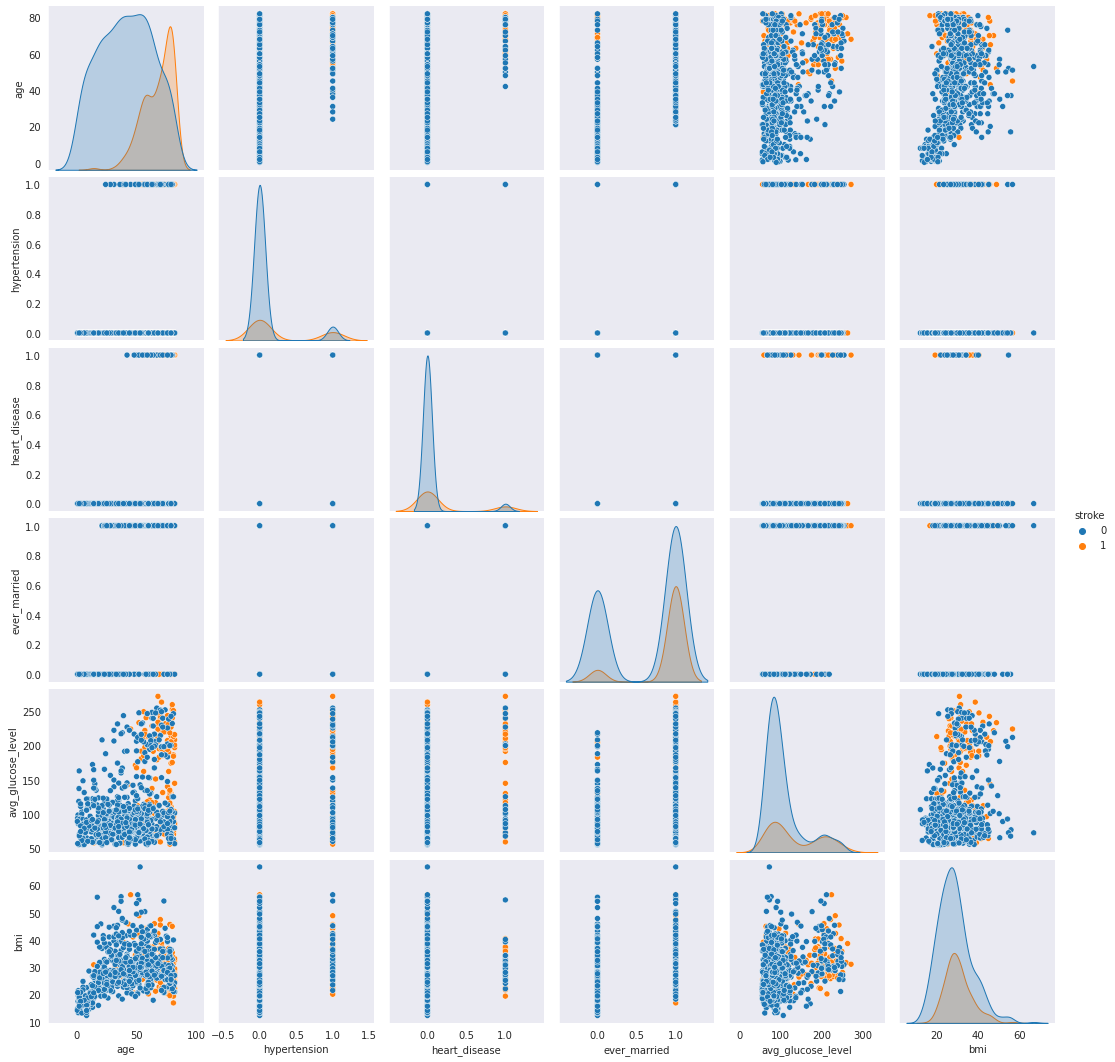

In [8]:
sns.pairplot(stroke, hue= 'stroke');

## Naive Bayes

To start off, I first took all the numeric data and and divided them up into 4 categories.  From there, I then used OrdinalEncoder for all features to use Categorical Naive Bayes from sklearn.

In [9]:
X = stroke.copy().drop(['stroke'], axis = 1)

for col in numeric:
    X[col] = pd.qcut(X[col], q = 4)

y = stroke.stroke
encoder = OrdinalEncoder()
X = pd.DataFrame(encoder.fit_transform(X), columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size= 0.30, random_state= 42)

nb = CategoricalNB().fit(X_train, y_train)
print(f'train:\t{nb.score(X_train, y_train)}')
print(f'test:\t{nb.score(X_test, y_test)}')

train:	0.7879858657243817
test:	0.7283950617283951


We can see the accuracy is ok, but I'm hoping to do better with other models.  I transformed the data by one hot encoding all categorical features and then standard scaled the numerical data.  Finally, I split the data for 30% test size.

In [10]:
X = pd.get_dummies(stroke, columns= dummies)
y = stroke.stroke

X.drop(['stroke'], axis= 1, inplace= True)

scaler = StandardScaler()
# encoder = OrdinalEncoder()

transformer = ColumnTransformer(transformers= [(
    # ('cat', encoder, dummies),
    ('num', scaler, numeric)
    )], remainder = 'passthrough')

columns = numeric + X.drop(numeric, axis=1).columns.tolist()

Xscaled = pd.DataFrame(transformer.fit_transform(X), columns = columns)

X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size= 0.30, random_state= 42)



I then took the data and ran PCA transform on the train and test sets for a Guassian Naive Bayes to see if I can get any better accuracy scores.

In [11]:
pca = PCA(n_components= 0.99)
proj_train = pca.fit_transform(X_train)
proj_test = pca.transform(X_test)
pca.n_components_

13

In [12]:
nb = GaussianNB().fit(proj_train, y_train)
print(f'train:\t{nb.score(proj_train, y_train)}')
print(f'test:\t{nb.score(proj_test, y_test)}')

train:	0.7791519434628975
test:	0.7119341563786008


The score for a Gaussian NB wasn't much better.

## Random Forest

Next up, I tested if Random Forest would be any better.  With some minor hyperparameter tuning of max depth and n estimators.

In [13]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 2]
}

# forest = RandomForestClassifier().fit(X_train, y_train)

grid = GridSearchCV(RandomForestClassifier(), param_grid)
grid.fit(X_train, y_train)
forest = grid.best_estimator_

print(grid.best_params_)
print(f'train:\t{forest.score(X_train, y_train)}')
print(f'test:\t{forest.score(X_test, y_test)}')

{'max_depth': 2, 'n_estimators': 10}
train:	0.7508833922261484
test:	0.7325102880658436


These results were essentially the same as the Naive Bayes earlier. While I was testing, I included hyperparameter tuning for max_depth of "None" included in the grid search, that resulted in overfitting. The train had perfect accuracy, while the test set was about 74%, which didn't really encourage me.

## SVM Classifier

The next model I tried was SVM classifier.

In [14]:
param_grid = {
    'C': [0.1, 0.5, 1.0],
    'degree': [1, 2, 3],
    'kernel': ['rbf', 'sigmoid']
}

# svc = SVC().fit(X_train, y_train)

grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train, y_train)
svc = grid.best_estimator_

print(grid.best_params_)
print(f'train:\t{svc.score(X_train, y_train)}')
print(f'test:\t{svc.score(X_test, y_test)}')

{'C': 0.5, 'degree': 1, 'kernel': 'sigmoid'}
train:	0.765017667844523
test:	0.7777777777777778


The Scores for the SVM classifier weren't much better than the rest of the scores.

## Logistic Regression

I decided to throw in Logistic Regression just so I can have a quantify the results to the SVM classifier, but I'm not expecting much better.

In [15]:
param_grid = {
    'C': [0.1, 0.5, 1]
}

grid = GridSearchCV(LogisticRegression(), param_grid)

grid.fit(X_train, y_train)
clf = grid.best_estimator_

print(grid.best_params_)
print(f'train:\t{clf.score(X_train, y_train)}')
print(f'test:\t{clf.score(X_test, y_test)}')

{'C': 0.1}
train:	0.8127208480565371
test:	0.7613168724279835


The logistic regression model performed better in training data, but did about the same for testing model to the SVM classifier.  I was kind of surprised to see the training data do better, I was expecting more identical results to the SVM.

## TesorFlow

Finally, I wanted to try a bit of Tensorflow.

In [16]:
model = keras.models.Sequential([
    Dense(15, activation= 'relu', input_shape= X_train.shape[1:]),
    Dense(10, activation= 'relu'),
    Dense(1, activation= 'sigmoid')
])

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['acc'])
history = model.fit(X_train, y_train, batch_size= 8, 
                    epochs= 100, verbose= 1, validation_split= 0.20)

Epoch 1/100
57/57 [==============================] - 1s 9ms/step - loss: 0.6103 - acc: 0.7014 - val_loss: 0.5556 - val_acc: 0.7105
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 0.5310 - acc: 0.7230 - val_loss: 0.5055 - val_acc: 0.7281
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 0.4358 - acc: 0.7705 - val_loss: 0.4767 - val_acc: 0.7368
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 0.3963 - acc: 0.7835 - val_loss: 0.4519 - val_acc: 0.7544
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 0.3923 - acc: 0.8095 - val_loss: 0.4394 - val_acc: 0.7807
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 0.4064 - acc: 0.7979 - val_loss: 0.4364 - val_acc: 0.7895
Epoch 7/100
57/57 [==============================] - 0s 2ms/step - loss: 0.3697 - acc: 0.8443 - val_loss: 0.4332 - val_acc: 0.7807
Epoch 8/100
57/57 [==============================] - 0s 2ms/step - loss: 0.3630 - a

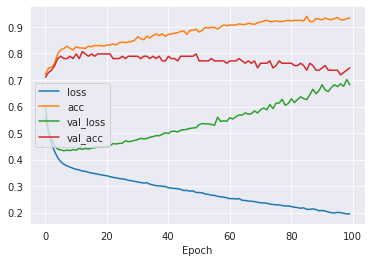

In [17]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.xlabel('Epoch')
plt.show()


In [18]:
tf_train = model.evaluate(X_train, y_train, verbose= 1)[1]
tf_train

18/18 [==============================] - 0s 941us/step - loss: 0.2851 - acc: 0.8940


0.8939929604530334

In [19]:
score = model.evaluate(X_test, y_test, verbose= 1)
tf_test = score[1]
tf_test

8/8 [==============================] - 0s 1ms/step - loss: 0.6049 - acc: 0.7325


0.7325102686882019

Even Tensorflow did not score significantly better.  It did do the best for training score accuracy, but about the same for testing scores.

In conclusion, different models do not appear to have a significant better chance of predicting if a patient will have a stroke.  I used to think TensorFlow would perform significantly better than any other machine learning models, but working with it in this data made me realize that it has the same limitations as other models.  Before I had limited the number of non stroke patients, I was getting accuracies approximately 98%.